In [2]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

train_path = './train'
test_path = './test'

person_dir = '/person/'
wildboar_dir = '/wildboar/'
waterdeer_dir = '/waterdeer/'

In [3]:
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [4]:
resize_train[0][0].shape

torch.Size([3, 128, 128])

In [5]:
resize_train[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [6]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2))

array([0.91236836, 0.90609443, 0.91076636], dtype=float32)

In [7]:
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)

In [8]:
get_mean_std(resize_train)
get_mean_std(resize_test)

0.5619613 0.54894084 0.46700037
0.19371323 0.18722515 0.18210617
0.5581136 0.53221834 0.4566776
0.19759502 0.19191359 0.1899485


In [10]:
resize_train_mean=[0.5619613, 0.54894084, 0.46700037]
resize_train_std=[0.19371323, 0.18722515, 0.18210617]

resize_test_mean=[0.5581136, 0.53221834, 0.4566776]
resize_test_std=[0.19759502, 0.19191359, 0.1899485]

In [11]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images.shape

torch.Size([1, 3, 124, 124])

In [16]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

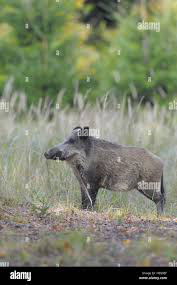

In [17]:
none_trans[359][0]

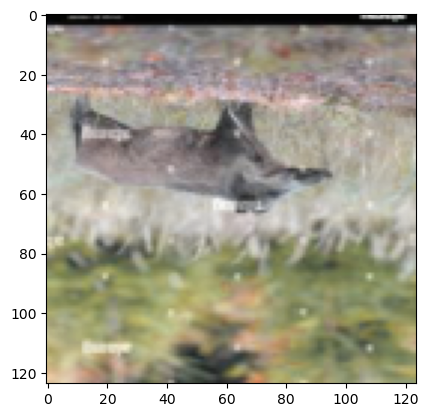

In [18]:
imshow((trainset[359][0]),resize_train_mean,resize_train_std)

In [26]:
train_path = './train'
test_path = './test'

Dataset_path = './'

person_dir = '/person/'
wildboar_dir = '/wildboar/'
waterdeer_dir = '/waterdeer/'

In [60]:
from torch.utils.data import Dataset, DataLoader # 데이터 커스터마이징
from PIL import Image # PIL = Python Image Library
import cv2 # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

class N_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 이름을 활용해 label 부여
    label=[]                                
    if os.path.basename(data_path).startswith("person") == True:
        label = 0
    elif os.path.basename(data_path).startswith("wildboar") == True: 
        label = 1
    else :
        label = 2
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

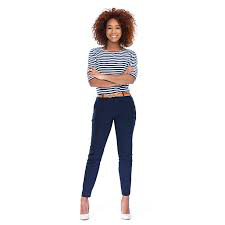

In [61]:
Image.open(N_Dataset(Dataset_path,'train', transform = None).all_data[0])


In [62]:
import albumentations
import albumentations.pytorch

albumentations_resize = albumentations.Compose([
                                                
    albumentations.Resize(128, 128), 
    albumentations.pytorch.transforms.ToTensorV2()
    
])

resize_train=N_Dataset(Dataset_path, 'train', transform=albumentations_resize)
resize_test=N_Dataset(Dataset_path, 'test', transform=albumentations_resize)

In [63]:
def tensor_img(img):    
    img = img.permute(1,2,0)
    plt.imshow(img)

In [64]:
resize_train[220][0].numpy().shape

(3, 128, 128)

In [65]:
resize_train[220][0].permute(1,2,0).shape

torch.Size([128, 128, 3])

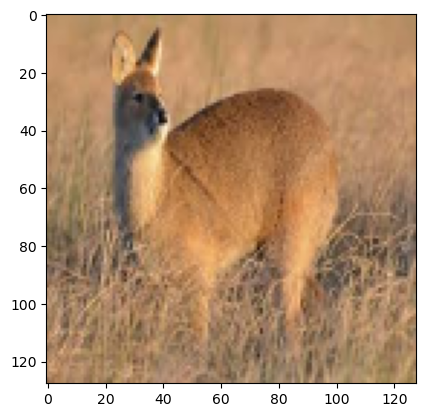

In [66]:
tensor_img(resize_train[220][0])

In [69]:
import albumentations
import albumentations.pytorch
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더

albumentations_train = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),   
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.8), # p확률로 이미지 좌우 반전
                          albumentations.RandomRotate90(p=0.8), # p확률로 90도 회전
                          albumentations.VerticalFlip(p=0.8) # p확률로 이미지 상하 반전
    ], p=1),

    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.8), # p확률로 이미지를 흐리게(?) 만들어 줌
                          albumentations.OpticalDistortion(p=0.8), # p확률로 이미지 왜곡
                          albumentations.GaussNoise(p=0.8) # 임의의 noise를 삽입          
    ], p=1),
    albumentations.Normalize(mean = resize_train_mean, std = resize_train_std),
    albumentations.pytorch.ToTensorV2()
    
])

albumentations_test = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),
    albumentations.pytorch.ToTensorV2()
    
])


trainset=N_Dataset(Dataset_path, 'train', transform=albumentations_train)
testset=N_Dataset(Dataset_path, 'test', transform=albumentations_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)
     

In [70]:
trainset[222][0]

tensor([[[-0.0466, -0.1073, -0.2288,  ..., -0.5729, -0.1275, -0.3502],
         [-0.0466, -0.1073, -0.2288,  ..., -0.5729, -0.1275, -0.3502],
         [-0.0263, -0.0466, -0.0263,  ..., -0.3907, -0.0263, -0.7146],
         ...,
         [-1.0588, -0.3300, -0.5527,  ..., -0.9980, -1.0385, -0.9576],
         [-1.2005, -0.8361, -0.7551,  ..., -0.9576, -1.0183, -0.9576],
         [-0.9576, -0.4717, -0.2490,  ..., -0.8361, -0.7956, -0.7349]],

        [[ 0.1261,  0.0423, -0.0834,  ..., -0.1671,  0.2937,  0.0423],
         [ 0.1261,  0.0423, -0.0834,  ..., -0.1671,  0.2937,  0.0423],
         [ 0.1261,  0.1051,  0.1261,  ...,  0.0423,  0.4193, -0.2928],
         ...,
         [-0.6698,  0.0842, -0.1671,  ..., -0.5232, -0.5651, -0.4604],
         [-0.8374, -0.4604, -0.3766,  ..., -0.4813, -0.5442, -0.4604],
         [-0.5861, -0.0834,  0.1261,  ..., -0.3347, -0.3347, -0.2509]],

        [[-0.1095, -0.1526, -0.1956,  ..., -0.6694, -0.1956, -0.4541],
         [-0.1095, -0.1526, -0.1956,  ..., -0

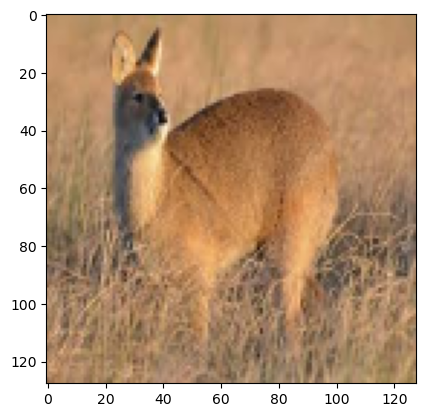

In [72]:
plt.imshow(resize_train[220][0].permute(1,2,0))
